In [1]:
# Dataloading Stuff
from google.colab import drive
import sys
import os
import operator
import collections
from importlib import reload


# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd

!pip3 install nltk
from nltk import word_tokenize, sent_tokenize, download
download('punkt')

drive.mount('/content/drive', force_remount=True)

     |████████████████████████████████| 2.0MB 7.6MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!rm -rf vocab_city 
!mkdir vocab_city

In [4]:
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel'
vocab_root = '/Notebooks/Experiments/word-cloud/vocab_city'
sys.path.append(path_root)
data_root = '/data/'

In [5]:
import util

In [6]:
def retain_classes(text, labels, allowed_labels):
  indexes = []
  for c,value in enumerate(labels):
    if value not in allowed_labels:
      indexes.append(c)

  for index in sorted(indexes, reverse=True):
    del text[index]
    del labels[index]


def avg_important_word_number(samples, labels, vocab, threshold):
    size = 0
    for i, sample in enumerate(samples):
        
        # if(i%1000==0):
        #     print(i)
            
        df = vocab[labels[i] + '_' + 'words']
        for word in word_tokenize(sample):
            try:
                if df[df.term == word].iloc[0,3] > threshold:
                    size += 1
            except IndexError:
                    size += 0 
    return size / len(samples)

def __false_negative_words__(clf, categories, X_val, y_val, vocab):
    
    ## clf: model
    ## categories: list of classses
    ## X_val
    ## y_val
    ## vocab: dict of cat as keys and dataframe as vocab learned by the model for that class
    
    ## return
    ## fn_word: dict with keys as class and values as FN and word
    ##          FN: dict with keys as fals negative classes and all sentences and important words as keys
    ##          word: df of all fn_words with their gv and fn_class
    
    predict = clf.predict(X_val)
    fn_word = {}
    for cat in categories:
        class_vocab = vocab[cat+ "_words"].set_index('term', inplace=False)
        FN = collections.defaultdict(list)
        word = []
        for i, label in enumerate(y_val):
            if label == cat and predict[i] != cat:
                sentence = X_val[i].split()
                top_words = clf.extract_insight(X_val[i], predict[i],window_size=0)
                FN_word_sentence = []
                for top_word in list(set(top_words)):
                    insert = [X_val[i]]
                    insert.extend([top_word[0], top_word[1], predict[i], sentence.count(top_word[0])])
                    try:
                        # insert.append(class_vocab.loc[top_word[0], 'gv'])
                        insert.append(clf.cv(top_word[0].lower(), cat))
                    except KeyError:
                        insert.append("word not in vocab of "+ cat)
                    word.append(insert)
                    FN_word_sentence.append(insert)
                FN[predict[i]].append(FN_word_sentence)
        fn_word[cat] = (dict(FN),pd.DataFrame(word, columns =['sentence', 'fn_word', 'cv', 'fn_class', 'count', 'cv_trueclass']))
    return fn_word
    

In [20]:
with open(path_root + data_root + 'CityReview/test.txt', 'r') as text_file:
  text = text_file.read().split('\n')

with open(path_root + data_root + 'CityReview/test_label.txt', 'r') as label_file:
  labels = label_file.read().split('\n')
del text[-1]
del labels[-1]


reduce_class = 0
allowed_labels = ['Food', 'Staff', 'Price', 'Ambience', 'Anecdotes', 'Miscellaneous']
if reduce_class:
  retain_classes(text, labels, allowed_labels)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

Text(0, 0.5, '# of samples')

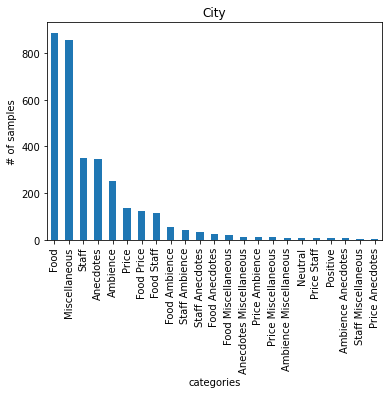

In [9]:
# pd.Series(labels).value_counts().plot(kind ='bar')
ax = pd.Series(labels).value_counts().plot(kind ='bar', title='City')
ax.set_xlabel("categories")
ax.set_ylabel("# of samples")

In [10]:
print(len(text))
print(len(labels))
# print(labels)

3327
3327


Training on 'Staff Miscellaneous': 100%|██████████| 23/23 [00:00<00:00, 88.84it/s]



                         precision    recall  f1-score   support

               Ambience       0.57      0.43      0.49        53
     Ambience Anecdotes       0.00      0.00      0.00         1
 Ambience Miscellaneous       0.37      0.61      0.46        61
              Anecdotes       0.00      0.00      0.00         4
Anecdotes Miscellaneous       0.74      0.56      0.63       167
                   Food       0.00      0.00      0.00        12
          Food Ambience       0.00      0.00      0.00         4
         Food Anecdotes       0.00      0.00      0.00         7
     Food Miscellaneous       0.17      0.26      0.21        27
             Food Price       0.60      0.12      0.20        25
             Food Staff       0.48      0.66      0.55       180
          Miscellaneous       0.00      0.00      0.00         1
                Neutral       0.00      0.00      0.00         0
               Positive       0.50      0.24      0.33        29
                  Price

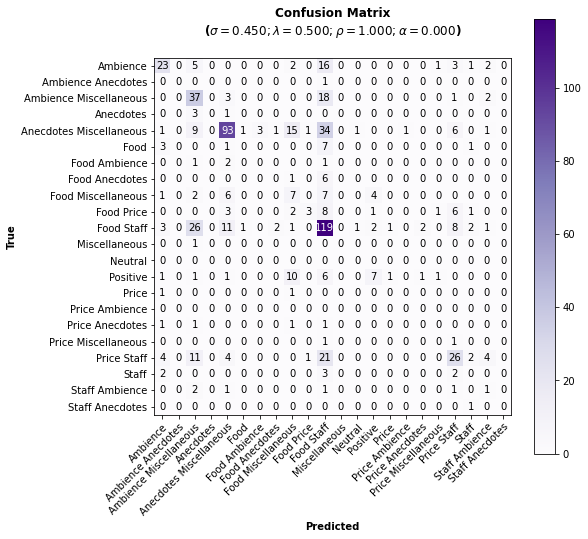

0.14813290485421837

In [22]:
clf = SS3(cv_m='gv')
clf.fit(X_train, y_train)
Evaluation.test(clf, X_val, y_val, metric="f1-score")

In [23]:
clf.print_categories_info()
clf.save_vocab(path='./vocab_city')



 CATEGORIES:

	       Category         | Index |   Length   | Vocab. Size | Word Max. Fr. | N-gram |
	------------------------|-------|------------|-------------|---------------|--------|
	       Ambience         |   0   |    3259    |     933     |      194      |   1    |
	  Ambience Anecdotes    |   1   |     92     |     65      |       6       |   1    |
	Ambience Miscellaneous  |   2   |    170     |     117     |      11       |   1    |
	       Anecdotes        |   3   |    4224    |    1000     |      176      |   1    |
	Anecdotes Miscellaneous |   4   |    260     |     135     |      18       |   1    |
	         Food           |   5   |   10592    |    2091     |      794      |   1    |
	     Food Ambience      |   6   |    1009    |     450     |      74       |   1    |
	    Food Anecdotes      |   7   |    311     |     198     |      16       |   1    |
	  Food Miscellaneous    |   8   |    325     |     189     |      21       |   1    |
	      Food Price        | 

In [24]:
vocab = {}
categories = list(set(labels))
grams = ["words"]
for gram in grams:
  for cat in categories:
    try:
      vocab[cat + '_' + gram] = pd.read_csv("/content/vocab_city/ss3_vocab_"+ cat +"(" + gram + ").csv")
    except FileNotFoundError as e:
      print("File not found for", cat)

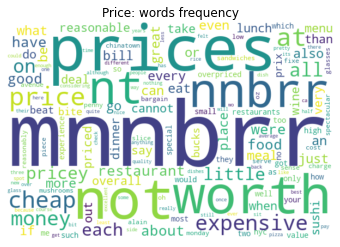

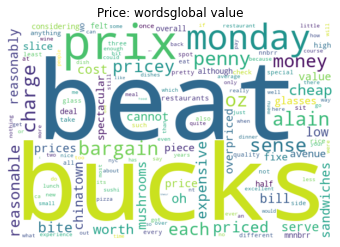

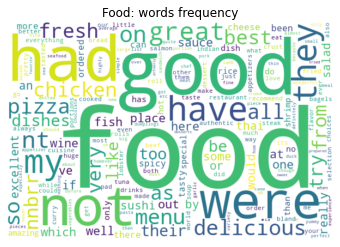

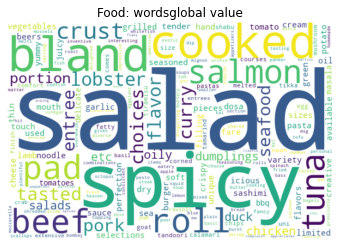

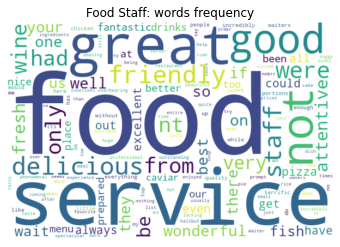

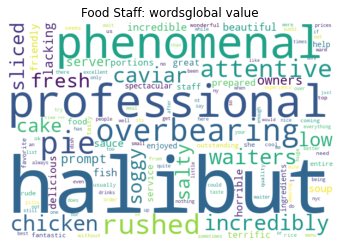

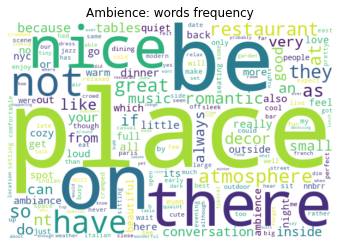

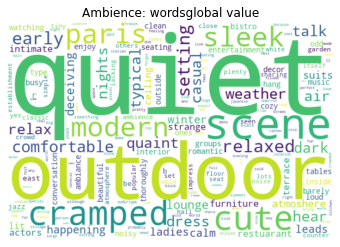

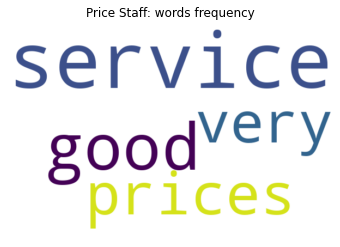

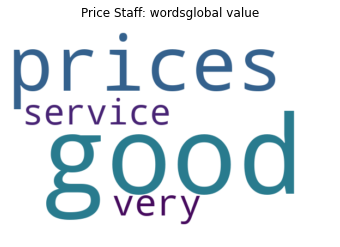

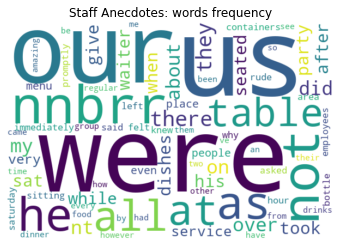

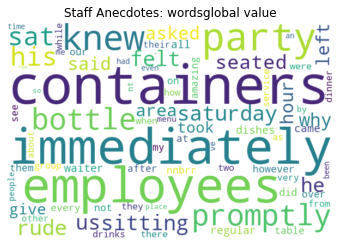

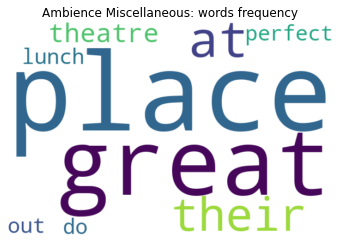

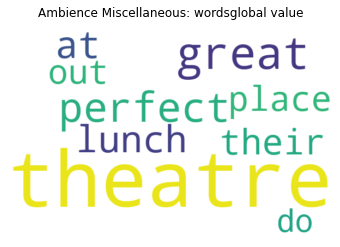

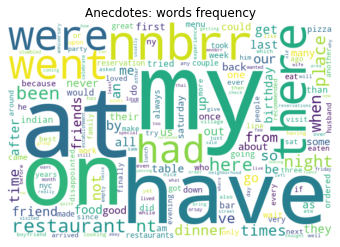

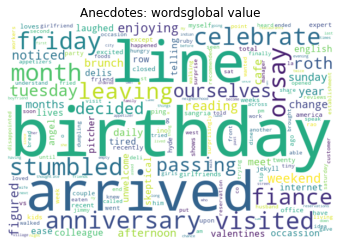

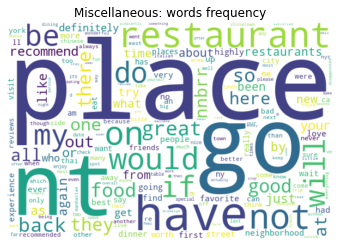

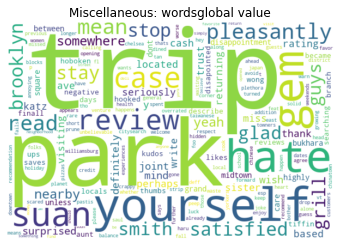

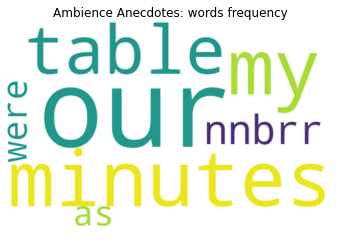

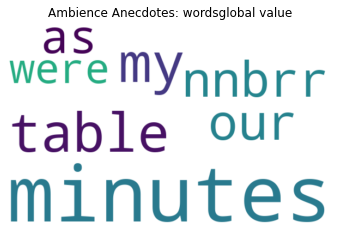

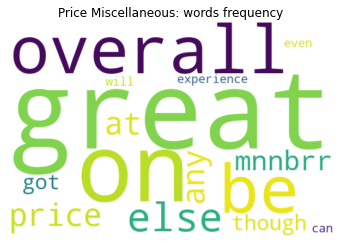

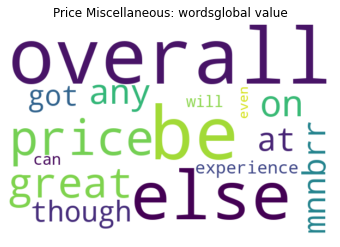

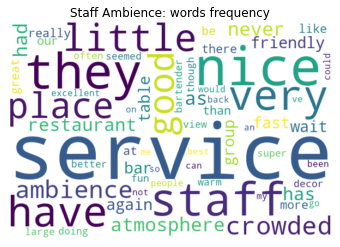

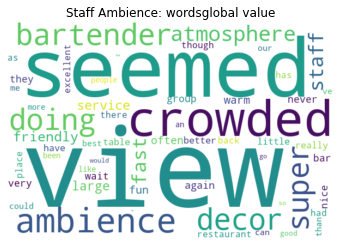

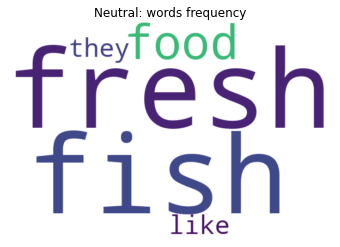

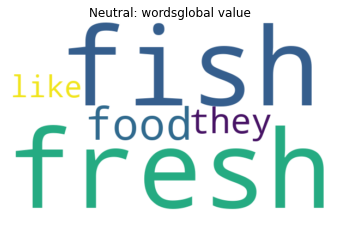

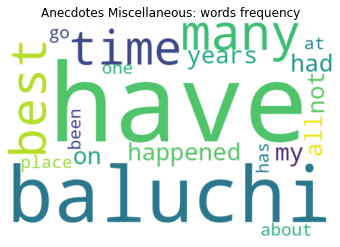

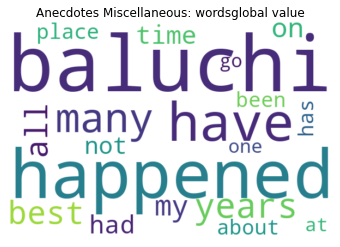

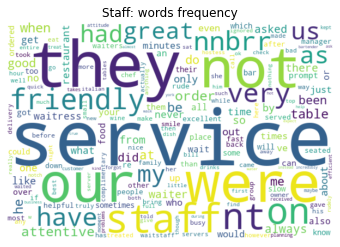

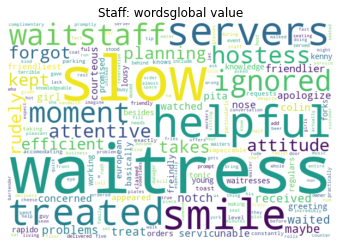

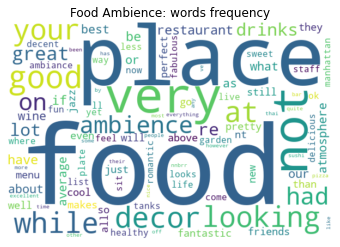

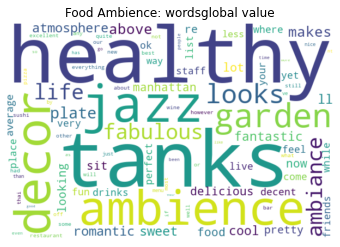

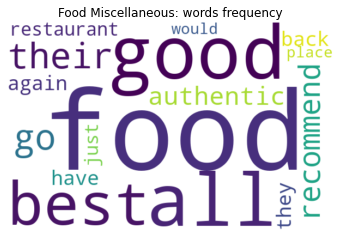

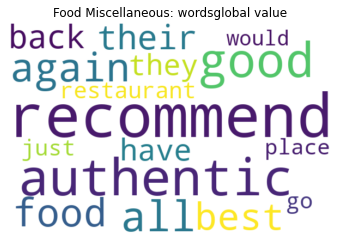

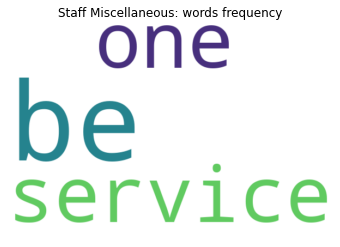

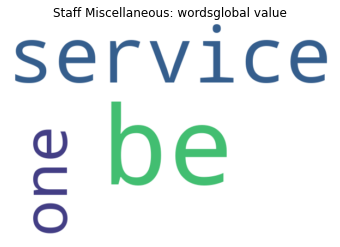

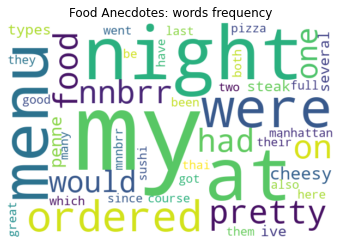

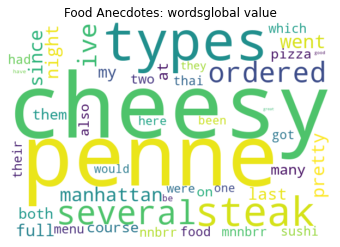

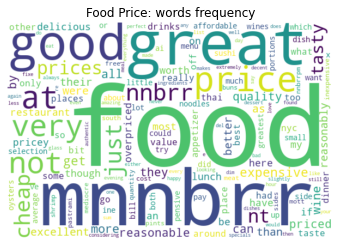

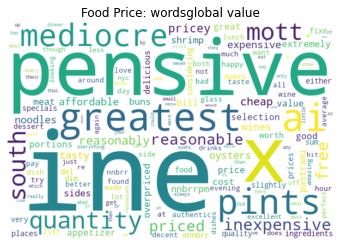

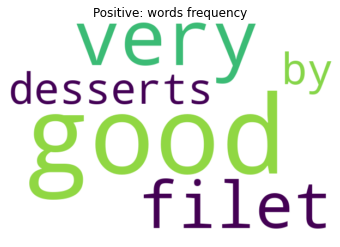

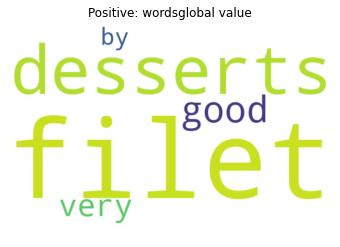

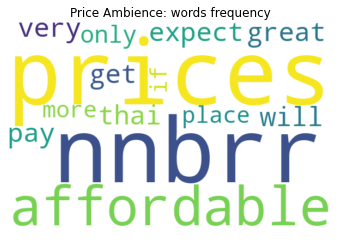

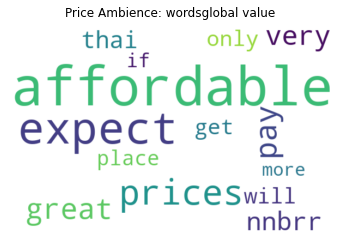

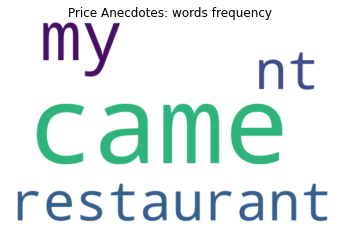

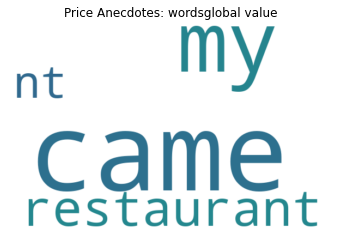

In [14]:
for cat in categories:
  for gram in ["words"]:
      for col in ["fr", "gv"]:
          df = vocab[cat + '_' + gram]
          df1 = df[["term",col]]
          count = df1.set_index('term').T.to_dict('records')[0]

          wordcloud = WordCloud(height =400,width = 600,max_font_size = 200,background_color="white").generate_from_frequencies(count)
          plt.figure()
          plt.imshow(wordcloud, interpolation="bilinear")
          plt.title(cat + ": " + gram + " frequency") if col == "fr" else plt.title(cat + ": " + gram + "global value")
          plt.axis("off")
          plt.show()

In [ ]:
# for cat in categories:
#   for gram in ["words"]:
#     try:
#       df = vocab[cat + '_' + gram]
#     except KeyError as e:
#       # print(cat,"_", gram ,": NO FILE")
#       print("")
#     else:
#       above_threshold = df[df.gv > 0.2].count()["term"]
#       total = df.describe()["fr"]["count"]
#       percentage = (above_threshold/total)*100
#       print(cat,"_", gram ,":         percentage=", round(percentage,2),", above threshold=", above_threshold,", total=", total)
#   print("            ")  
# # vocab['Staff Anecdotes_words']

In [ ]:
# important_words = avg_important_word_number(X_train, y_train, vocab, 0.2)

In [ ]:
# words = util.avg_word_number(X_train, y_train)

In [ ]:
# print("percentage of average important words per sample: ", (important_words/words)*100)

In [25]:
fn_word = __false_negative_words__(clf, categories, X_val, y_val, vocab)

Classification: 100%|██████████| 666/666 [00:00<00:00, 45691.68it/s]


In [26]:
true_class = 'Staff'
fn_class = 'Food'
## word frequency in false_negative class ##
a = fn_word[true_class][1]
b = a[a.fn_class == fn_class].groupby(['fn_word','fn_class'], as_index=False).agg({'count': sum}).sort_values('count', ascending=False)

In [27]:
a[a.fn_class == fn_class]

sentence  ... cv_trueclass
84        Got club soda , filled with ice , no lime .   ...     0.000000
85        Got club soda , filled with ice , no lime .   ...     0.020576
86        Got club soda , filled with ice , no lime .   ...     0.020260
87        Got club soda , filled with ice , no lime .   ...     0.000000
88        Got club soda , filled with ice , no lime .   ...     0.000000
89    We both opted for a pasta dish and they were ...  ...     0.082763
90    We both opted for a pasta dish and they were ...  ...     0.000000
91    We both opted for a pasta dish and they were ...  ...     0.027515
92    We both opted for a pasta dish and they were ...  ...     0.000000
93    We both opted for a pasta dish and they were ...  ...     0.013681
94    We both opted for a pasta dish and they were ...  ...     0.021583
124                            The service is awful .   ...     0.000000
164   For instance , plates were just dumped on the...  ...     0.030502
165   For instance , plates were just dumped on the...  ...     0.017349
166   For instance , plates were just dumped on the...  ...     0.016662
167   For instance , plates were just dumped on the...  ...     0.014551
168   For instance , plates were just dumped on the...  ...     0.017380
169   For instance , plates were just dumped on the...  ...     0.000000
170   For instance , plates were just dumped on the...  ...     0.000000
171   For instance , plates were just dumped on the...  ...     0.021583
172   For instance , plates were just dumped on the...  ...     0.000000
286   Note that they do not serve beer , you must b...  ...     0.023687
287   Note that they do not serve beer , you must b...  ...     0.021013
288   Note that they do not serve beer , you must b...  ...     0.000000
289   Note that they do not serve beer , you must b...  ...     0.000000
290   Note that they do not serve beer , you must b...  ...     0.000000
291   Note that they do not serve beer , you must b...  ...     0.000000

[27 rows x 6 columns]

In [28]:
a[a.fn_class == fn_class].sentence.unique()

array([' Got club soda , filled with ice , no lime . ',
       ' We both opted for a pasta dish and they were served timely and fresh . ',
       ' The service is awful . ',
       ' For instance , plates were just dumped on the table , I was handed the wine list upside down , etc .... Somehow working the italian charm with constant mille grazie does not constitute proper service . ',
       ' Note that they do not serve beer , you must bring your own . '],
      dtype=object)

In [29]:
sentence = " The service is not consistently excellent -- just decent . "
sentence1 = " Only drawback - they wo n't toast your bagel , and they do n't make eggs for the bagel . "
sentence2 = ' in an effort to increase turnover , the restaurant offers no desserts beyond the complimentary espresso cup filled with chocolate mousse . '
a[(a.fn_class == fn_class) & ((a.sentence == sentence) |(a.sentence == sentence1) |(a.sentence == sentence2))]

Empty DataFrame
Columns: [sentence, fn_word, cv, fn_class, count, cv_trueclass]
Index: []

**Classification with few major classes**

**ALL METRICS**

In [ ]:
!rm -rf vocab && mkdir vocab
util = reload(util)
print("Avg Number of Sentences", util.avg_sent_number(X_train, y_train))
print("Avg Number of Paragraphs", util.avg_para_number(X_train, y_train))
overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'fr')
print("Overlap Ratio All Words", ratio)

!rm -rf vocab_five && mkdir vocab_five
overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'gv', True, 0.2)
print("Overlap Ratio Important Words", ratio)

Avg Number of Sentences 1.0822689706987227
Avg Number of Paragraphs 1.0
Overlap Ratio All Words 0.45051903114186853
Overlap Ratio Important Words 0.0


In [ ]:
clf.classify_label("Only drawback - they wo n't toast your bagel , and they do n't make eggs for the bagel .")
clf.extract_insight("Only drawback - they wo n't toast your bagel , and they do n't make eggs for the bagel .", cat='Staff', window_size=0)

[('toast', 0.449511457184981),
 ('they', 0.34400249406569217),
 ('they', 0.34400249406569217),
 ("n't", 0.1804845427921845),
 ("n't", 0.1804845427921845),
 ('wo', 0.16694940679072512),
 ('make', 0.1374485462381268),
 ('bagel', 0.13618049549273845),
 ('bagel', 0.13618049549273845),
 ('do', 0.11490446020772715),
 ('your', 0.07795161363375373),
 ('Only', 0.04994275414307329)]